In [1]:
import numpy as np
import torch 
import torch.nn as nn
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import os 

In [2]:
bs = 1024
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
def get_model_parameters(model):
    latent = True
    encoder_params = []
    decoder_params = []
    for param in model.parameters():
        if len(param.shape) == 2:
            if param.shape[1] == model.param_split:
                latent = False
        if latent:
            encoder_params.append(param)
        else:
            decoder_params.append(param)
    all_params = encoder_params + decoder_params

    return all_params, encoder_params, decoder_params

def grad_switch(params, grad_bool=False):
    for param in params:
        param.requires_grad = grad_bool

In [5]:
class PHI(nn.Module):
    def __init__(self):
        super(PHI, self).__init__()
        self.mu_e1_p = nn.Parameter()
        self.logvar_e1_p = nn.Parameter()

        self.mu_e2_p = nn.Parameter()
        self.logvar_e2_p = nn.Parameter()

#         self.mu_d1_p = nn.Parameter()
#         self.logvar_d1_p = nn.Parameter()

        self.mu_e1 = 0
        self.logvar_e1 = 0

        self.mu_e2 = 0
        self.logvar_e2 = 0
        
#         self.mu_d1 = 0
#         self.logvar_d1 = 0

In [47]:
class iHVAE(nn.Module):
    def __init__(self, z2_dim=10, z1_dim=20, n_iters = 20, eval_iters=500):
        super(iHVAE, self).__init__()
        
        self.latent_space_size1 = z1_dim
        self.latent_space_size2 = z2_dim
        
        self.param_split = z2_dim
        
        self.n_iters = n_iters
        self.eval_iters = eval_iters
        
        ## Encoder 1
        self.e1fc1 = nn.Linear(784, 512)
        self.e1fc2 = nn.Linear(512, 256)
        ## mu1 and logvar1
        self.e1fc4 = nn.Linear(256, z1_dim)
        self.e1fc5 = nn.Linear(256, z1_dim)
        
        ## Encoder 2
        self.e2fc1 = nn.Linear(z1_dim, 256)
        self.e2fc2 = nn.Linear(256, 128)
        ## mu2 and logvar2
        self.e2fc4 = nn.Linear(128, z2_dim)
        self.e2fc5 = nn.Linear(128, z2_dim)
        
        ## Decoder 2
        self.d2fc1 = nn.Linear(z2_dim, 128)
        self.d2fc2 = nn.Linear(128, 256)
        ## d_mu1 and d_logvar1
        self.d2fc4 = nn.Linear(256, z1_dim)
        self.d2fc5 = nn.Linear(256, z1_dim)

        ## Decoder 1
        self.d1fc1 = nn.Linear(z1_dim, 256)
        self.d1fc2 = nn.Linear(256, 512)
        self.d1fc4 = nn.Linear(512, 784)
    
    def encoder1(self, x):
        x = F.relu(self.e1fc1(x))
        x = F.relu(self.e1fc2(x))
        
        mu1 = self.e1fc4(x)
        logvar1 = self.e1fc5(x)
        
        return mu1, logvar1

    def encoder2(self, z2):
        z2 = F.relu(self.e2fc1(z2))
        z2 = F.relu(self.e2fc2(z2))
        
        mu2 = self.e2fc4(z2)
        logvar2 = self.e2fc5(z2)
        
        return mu2, logvar2

    def decoder2(self, z2):
        z1_rec = F.relu(self.d2fc1(z2))
        z1_rec = F.relu(self.d2fc2(z1_rec))
        
        d_mu1 = self.d2fc4(z1_rec)
        d_logvar1 = self.d2fc5(z1_rec)
        
        return d_mu1, d_logvar1

    def decoder1(self, z1):
        x_rec = F.relu(self.d1fc1(z1))
        x_rec = F.relu(self.d1fc2(x_rec))
        x_rec = self.d1fc4(x_rec)
        return x_rec

    def r_sampling(self, mu, logvar): 
        epsilon = torch.randn_like(mu)
        var = torch.exp(0.5*logvar)
        z = var.mul(epsilon).add(mu)
        return z, epsilon   
    
    def forward(self, x):
        phi = PHI()
        
        phi.mu_e1_p.data, phi.logvar_e1_p.data = self.encoder1(x)    
        
        optim_infer = torch.optim.Adam(phi.parameters(), lr=1e-2)
        inference_params = list(phi.parameters())
        
        
        grad_switch(inference_params, grad_bool=True)
        for infer_iter in range(self.n_iters):
            optim_infer.zero_grad()
            _, _, _, total_loss = self.iter_inference(x, phi)
            optim_infer.step()
        grad_switch(inference_params, grad_bool=False)
                
        return phi
    
    def forward_evaluate(self, x):
        phi = PHI()
        
        phi.mu_e1_p.data, phi.logvar_e1_p.data = self.encoder1(x)    
        
        optim_infer = torch.optim.Adam(phi.parameters(), lr=1e-3)
        inference_params = list(phi.parameters())
        
        
        grad_switch(inference_params, grad_bool=True)
        for infer_iter in range(self.eval_iters):
            optim_infer.zero_grad()
            _, _, _, total_loss = self.iter_inference(x, phi)
            optim_infer.step()
        grad_switch(inference_params, grad_bool=False)
                
        return phi
            
    def iter_inference(self, x, phi=None, mu=None, logvar=None, decoder=True, evaluate=False):
        if phi is not None:
            if decoder:
                mu, logvar = phi.mu_e1_p, phi.logvar_e1_p
                
        z1_sample, e_eps1 = self.r_sampling(mu, logvar)
        
        mu2, logvar2 = self.encoder2(z1_sample)
        if decoder:
            phi.mu_e2_p.data, phi.logvar_e2_p.data = mu2, logvar2
            
        z2_sample, e_eps2 = self.r_sampling(mu2, logvar2)
        
        mu_d1, logvar_d1 = self.decoder2(z2_sample)
        z1_rec_sample, d_eps1 = self.r_sampling(mu_d1, logvar_d1)
        
        x_rec = self.decoder1(z1_sample)
        
        z2_var_params = (mu2, logvar2, e_eps2) 
        z1_var_params = (mu, logvar, e_eps1) 
        d_z1_var_params = (mu_d1, logvar_d1, d_eps1)
        
        total_loss = hvae_loss(x, x_rec, z2_var_params, z1_var_params, d_z1_var_params)
        total_loss.backward()
        
        return x_rec, z1_sample, z2_sample, total_loss

In [48]:
def hvae_loss(x, x_rec, z2_var_params, z1_var_params, d_z1_var_params):
    """
    Working:
    Expanding the log of Normal distribution and expanding it in terms of z1 and z2
    """
    REC_ERROR = F.binary_cross_entropy(torch.sigmoid(x_rec), x, reduction='sum')    
    
    mu2, logvar2, epsilon2 = z2_var_params
    mu1, logvar1, epsilon1 = z1_var_params
    d_mu1, d_logvar1, d_epsilon1 = d_z1_var_params
    
    log_q_z1_x = torch.sum(-0.5*(epsilon1**2) - 0.5*logvar1, dim=-1)
    log_q_z2_z1 = torch.sum(-0.5*(epsilon2**2) - 0.5*logvar2, dim=-1)
    
    z2 = torch.exp(0.5*logvar2).mul(epsilon2).add(mu2)
    z1 = torch.exp(0.5*logvar1).mul(epsilon1).add(mu1)
    dvar1 = torch.exp(0.5*d_logvar1)
    
    log_p_z2 = torch.sum(-0.5*(z2**2), dim=-1)
    log_p_z1_z2 = torch.sum(-0.5*(((z1-d_mu1)/dvar1)**2) - 0.5*d_logvar1, dim=-1)

    ERROR_TERM2 = torch.mean(torch.sum(log_q_z1_x - log_p_z1_z2, axis=0))
    ERROR_TERM3 = torch.mean(torch.sum(log_q_z2_z1 - log_p_z2, axis=0))
    
    return REC_ERROR + ERROR_TERM2 + ERROR_TERM3

In [49]:
def evaluate(model, data):
    model.eval()
    
    phi = model(data)
    
    z1_sample, e_eps1 = model.r_sampling(phi.mu_e1_p, phi.logvar_e1_p)
    z2_sample, e_eps2 = model.r_sampling(phi.mu_e2_p, phi.logvar_e2_p)
    mu_d1, logvar_d1 = model.decoder2(z2_sample)
    d_z1_sample, d_eps1 = model.r_sampling(mu_d1, logvar_d1)
    
    x_rec = model.decoder1(z1_sample)

    z2_var_params = (phi.mu_e2_p, phi.logvar_e2_p, e_eps2) 
    z1_var_params = (phi.mu_e1_p, phi.logvar_e1_p, e_eps1) 
    d_z1_var_params = (mu_d1, logvar_d1, d_eps1)

    
    total_loss = hvae_loss(data, x_rec, z2_var_params, z1_var_params, d_z1_var_params)
    
    return total_loss

In [53]:
z1 = 20
z2 = 10
model = iHVAE(z1_dim=z1, z2_dim=z2).to(device)
optimizer_iHVAE = torch.optim.Adam(model.parameters(), lr=1e-3)

In [54]:
def train_iHVAE(epoch):
    model.train()
    total_loss = 0
    all_params, encoder_params, decoder_params = get_model_parameters(model)
    for idx, (X_train, y_train) in enumerate(train_loader):
        grad_switch(all_params, grad_bool=False)
        
        X_train = torch.flatten(X_train, start_dim=1).to(device)
        phi = model(X_train)

        # Updating decoding paramters
        grad_switch(decoder_params, grad_bool=True)
        optimizer_iHVAE.zero_grad()
        model.iter_inference(X_train, phi)
        optimizer_iHVAE.step()
        grad_switch(decoder_params, grad_bool=False)

        # Updating encoding paramters
        grad_switch(encoder_params, grad_bool=True)
        optimizer_iHVAE.zero_grad()
        
        mu1, logvar1 = model.encoder1(X_train)
#         z1_train = model.r_sampling(mu1, logvar1)
        
#         mu2, logvar2 = model.encoder2(z1_train)
#         z2_train = model.r_sampling(mu2, logvar2)
        
#         mu_params = mu1, mu2
#         logvar_params = (logvar1, logvar2)
        
        model.iter_inference(X_train, phi=phi, mu=mu1, logvar=logvar1, decoder=False)
        optimizer_iHVAE.step()
        grad_switch(encoder_params, grad_bool=False)
        
        loss = evaluate(model, X_train)
        total_loss+=loss
    total_loss/=(len(train_loader.dataset))
    print('For epoch {}, loss is {}'.format(epoch+1, total_loss))

In [55]:
epochs = 200
for e in range(epochs):
    train_iHVAE(e)

For epoch 1, loss is 217.78463745117188
For epoch 2, loss is 164.1765594482422
For epoch 3, loss is 139.84654235839844
For epoch 4, loss is 128.6719970703125
For epoch 5, loss is 122.36369323730469
For epoch 6, loss is 118.04949951171875
For epoch 7, loss is 115.13134765625
For epoch 8, loss is 112.88336944580078
For epoch 9, loss is 111.08975219726562
For epoch 10, loss is 109.66781616210938
For epoch 11, loss is 108.46359252929688
For epoch 12, loss is 107.44914245605469
For epoch 13, loss is 106.4971694946289
For epoch 14, loss is 105.68930053710938
For epoch 15, loss is 104.96714782714844
For epoch 16, loss is 104.34489440917969
For epoch 17, loss is 103.82469940185547
For epoch 18, loss is 103.3002700805664
For epoch 19, loss is 102.8399658203125
For epoch 20, loss is 102.47148132324219
For epoch 21, loss is 102.05291748046875
For epoch 22, loss is 101.69425964355469
For epoch 23, loss is 101.37762451171875
For epoch 24, loss is 101.0532455444336
For epoch 25, loss is 100.77490234

In [56]:
PATH = 'HiVAE_weights-paper.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model_test = iHVAE() 
model_test.load_state_dict(torch.load(PATH))
model_test = model_test.to(device)

In [13]:
def reconstruct_images(model, data):
    model.eval()
    phi = model(data)
    z1_sample, _ = model.r_sampling(phi.mu_e1_p, phi.logvar_e1_p)
    x_rec = model.decoder1(z1_sample)
    
    return x_rec

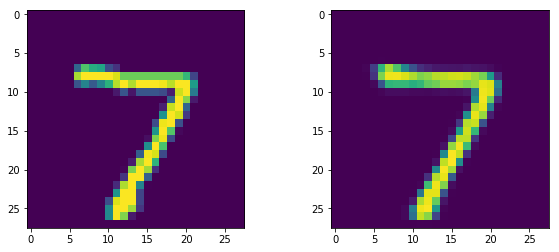

0


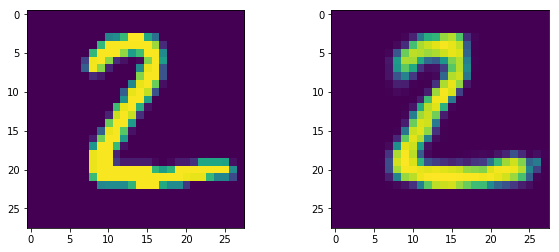

1


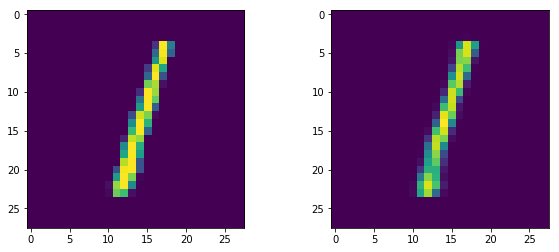

2


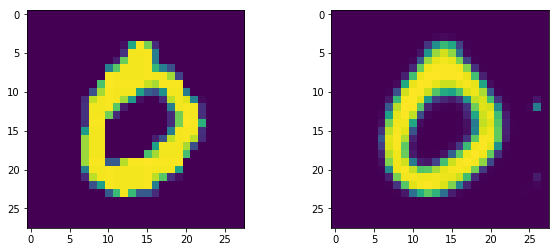

3


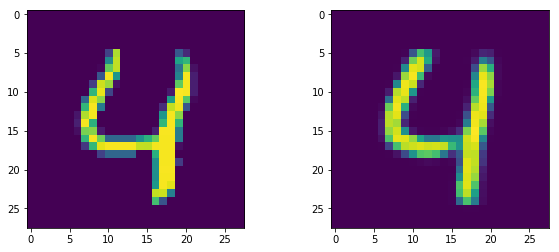

4


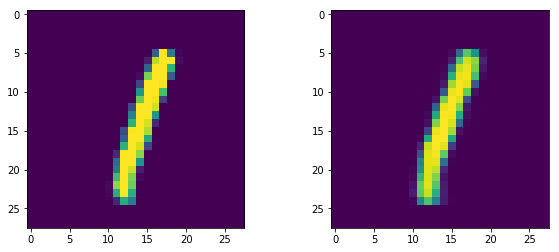

5


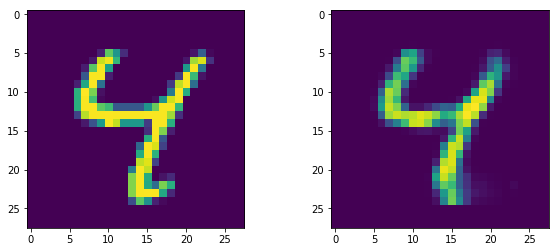

6


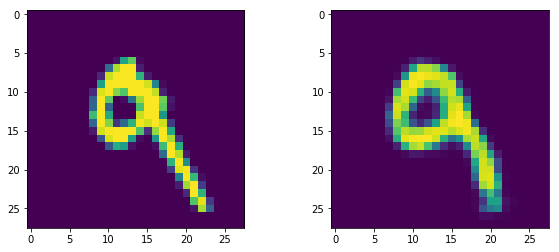

7


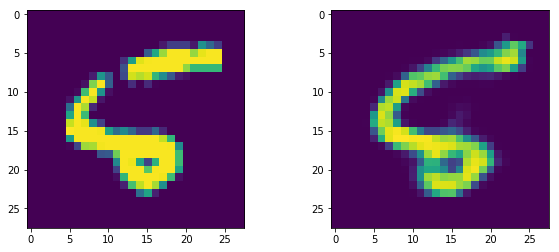

8


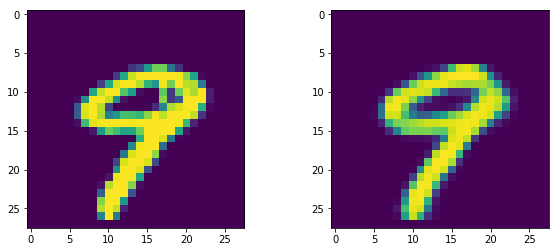

9


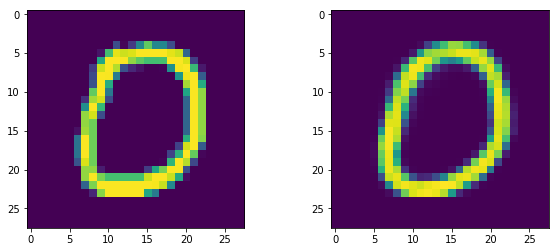

10


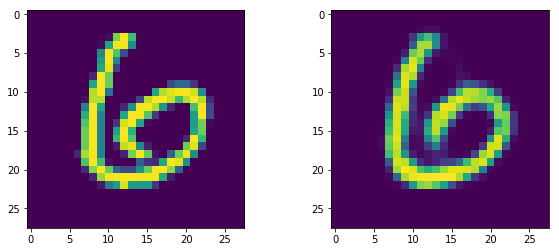

11


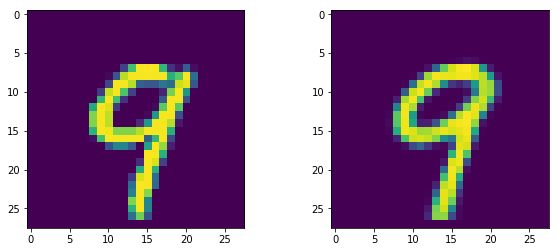

12


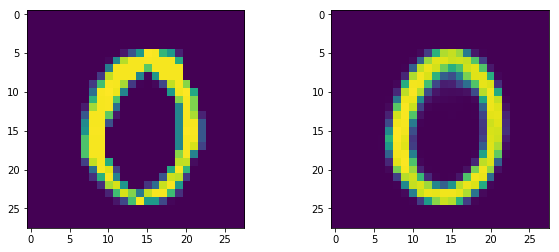

13


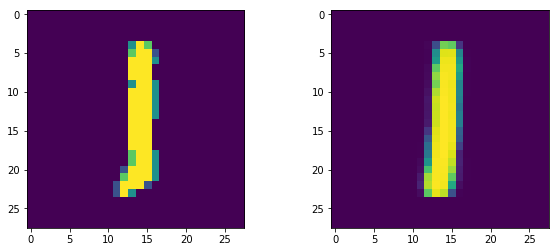

14


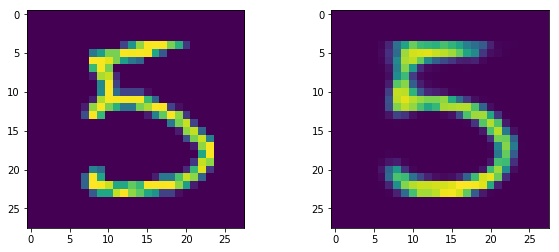

15


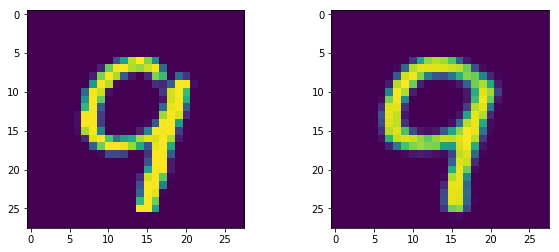

16


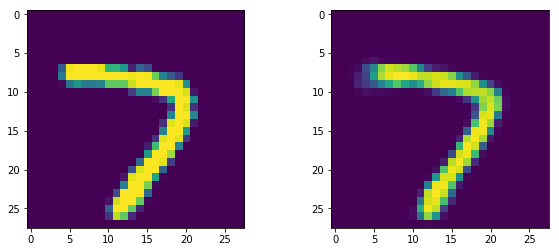

17


KeyboardInterrupt: 

In [57]:
import matplotlib.pyplot as plt 


for test_idx, (X_test, _) in enumerate(test_dataset):    
    x_test_sample = X_test[0].view(-1,784)
    x_test_sample = x_test_sample
    x_rec_test_sample = reconstruct_images(model, x_test_sample.to(device))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].imshow(x_test_sample.view(28,28).detach().numpy())
    ax[1].imshow(torch.sigmoid(x_rec_test_sample[0]).cpu().view(28,28).detach().numpy())
#     plt.savefig('./HVAE-Results/Reconstructions/test_reconstruction_{}.png'.format(test_idx))
    plt.show()
    print(test_idx)


In [16]:
## MNIST Classifier 

class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1) 
        self.maxpool1 = nn.MaxPool2d(2) # 14x14x32
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.maxpool2 = nn.MaxPool2d(2) # 7x7x64
        
        self.conv3 = nn.Conv2d(64, 16, kernel_size=(3,3), padding=1)
        self.maxpool3 = nn.MaxPool2d(2) # 3x3x16
        
        self.fc1 = nn.Linear(3*3*16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,10)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, bs):
        
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        
        x = x.view(-1, 3*3*16)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x        

In [17]:
classifier_mnist = classifier().to(device)

In [18]:
import torch.optim as optim

optimizer_classifier = optim.Adam(classifier_mnist.parameters(), lr=1e-3)

In [19]:
criterion_classifier = nn.CrossEntropyLoss()

In [20]:
def train_classifier(epoch):
    total_loss = 0
    for idx, (X_train, y_train) in enumerate(train_loader):
        y_pred = classifier_mnist(X_train.to(device), bs)
        loss = criterion_classifier(y_pred, y_train.to(device))
        
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()
        total_loss += loss.item()
    print('For epoch {}, loss is {}'.format(epoch, total_loss))

In [21]:
epochs = 20
for e in range(epochs):
    train_classifier(e)

For epoch 0, loss is 75.62339982390404
For epoch 1, loss is 18.112258449196815
For epoch 2, loss is 9.853487648069859
For epoch 3, loss is 7.190755970776081
For epoch 4, loss is 5.907568149268627
For epoch 5, loss is 5.047714427113533
For epoch 6, loss is 4.396524965763092
For epoch 7, loss is 4.076981969177723
For epoch 8, loss is 3.688246164470911
For epoch 9, loss is 3.253346398472786
For epoch 10, loss is 3.028335854411125
For epoch 11, loss is 3.029560524970293
For epoch 12, loss is 2.625402668491006
For epoch 13, loss is 2.49310683645308
For epoch 14, loss is 2.3602079562842846
For epoch 15, loss is 2.231247764080763
For epoch 16, loss is 2.1195983085781336
For epoch 17, loss is 1.9733759947121143
For epoch 18, loss is 1.9643505774438381
For epoch 19, loss is 1.7675113435834646


In [29]:
PATH = 'classifier_weights.pth'
torch.save(classifier_mnist.state_dict(), PATH)

In [22]:
import torch.distributions as tdist
def gaussian_noise(input, std=0.2):
    noise = torch.normal(mean=0, std=torch.ones_like(input)*std)
    return input + noise

In [59]:
model.eval()
hvae_total_correct = 0

for hvae_X_test, hvae_y_test, in test_loader:
    hvae_X_test = gaussian_noise(hvae_X_test, std=0)
    hvae_X_rec_test = reconstruct_images(model, hvae_X_test.view(-1,784).to(device))
    hvae_X_rec_test = hvae_X_rec_test.view(-1, 1, 28, 28)
    hvae_X_noise_test = torch.sigmoid(hvae_X_rec_test)
    hvae_y_pred_test = classifier_mnist(hvae_X_noise_test.to(device), bs) 
    hvae_correct = torch.sum((torch.argmax(hvae_y_pred_test, axis=1).eq(hvae_y_test.to(device)))).item()
    hvae_total_correct+=hvae_correct
hvae_test_accuracy = (hvae_total_correct/len(test_loader.dataset))*100
print('Test Accuracy for HVAE', hvae_test_accuracy)

Test Accuracy for HVAE 97.54
